In [292]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.linear_model import LinearRegression
import geoplot
from bokeh.io import curdoc
from bokeh.models import ColumnDataSource, Select
from bokeh.plotting import figure
from bokeh.layouts import row


cpi_df = pd.read_csv("ABS_CPI_1.1.0.csv")
turnover_df = pd.read_csv("ABS_RT.csv")

cpi_df = cpi_df[['REGION: Region', 'TIME_PERIOD: Time Period', 'OBS_VALUE','INDEX: Index']]
turnover_df = turnover_df[['REGION: Region', 'TIME_PERIOD: Time Period', 'OBS_VALUE', 'INDUSTRY: Industry']]
cpi_df = cpi_df.rename(columns={'REGION: Region': 'Region', 'TIME_PERIOD: Time Period': 'Time Period', 'OBS_VALUE': 'cpi','INDEX: Index':'Index'})
turnover_df = turnover_df.rename(columns={'REGION: Region': 'Region', 'TIME_PERIOD: Time Period': 'Time Period', 'OBS_VALUE': 'Turnover', 'INDUSTRY: Industry': 'Industry'})
turnover_df['Industry'].unique()

array(['20: Total', '44: Department stores',
       '43: Clothing, footwear and personal accessory retailing',
       '42: Household goods retailing', '45: Other retailing',
       '46: Cafes, restaurants and takeaway food services',
       '41: Food retailing'], dtype=object)

In [225]:
#Converting regions
region_mapping = {'4: Adelaide': '4: South Australia', '2: Melbourne': '2: Victoria', '6: Hobart': '6: Tasmania', '50: Weighted average of eight capital cities': 'AS: Australia', '5: Perth': '5: Western Australia', '3: Brisbane': '3: Queensland', '1: Sydney': '1: New South Wales'}

cpi_df['Region'] = cpi_df['Region'].replace(region_mapping)

#Converting time
turnover_df['Year'] = turnover_df['Time Period'].astype(str).str.split('-').str[0]
turnover_df['Month'] = turnover_df['Time Period'].astype(str).str.split('-').str[1]
month_to_quarter_mapping = {
    "01": "-Q1", "02": "-Q1", "03": "-Q1",
    "04": "-Q2", "05": "-Q2", "06": "-Q2",
    "07": "-Q3", "08": "-Q3", "09": "-Q3",
    "10": "-Q4", "11": "-Q4", "12": "-Q4"
}
turnover_df['Quarter'] = turnover_df['Month'].map(month_to_quarter_mapping)

#New Turnover Dataframe
quarterly_turnover = turnover_df.groupby(['Year', 'Quarter', 'Industry','Region'])['Turnover'].sum().reset_index()
quarterly_turnover['Time Period'] = quarterly_turnover['Year'] + quarterly_turnover['Quarter']
quarterly_turnover = quarterly_turnover.drop(['Year', 'Quarter'], axis=1)
print(quarterly_turnover)

                                               Industry                Region  \
0                                             20: Total    1: New South Wales   
1                                             20: Total           2: Victoria   
2                                             20: Total         3: Queensland   
3                                             20: Total    4: South Australia   
4                                             20: Total  5: Western Australia   
...                                                 ...                   ...   
1857  46: Cafes, restaurants and takeaway food services         3: Queensland   
1858  46: Cafes, restaurants and takeaway food services    4: South Australia   
1859  46: Cafes, restaurants and takeaway food services  5: Western Australia   
1860  46: Cafes, restaurants and takeaway food services           6: Tasmania   
1861  46: Cafes, restaurants and takeaway food services        AUS: Australia   

      Turnover Time Period 

In [168]:
#Turnover & cpi dataframe for total industry
quarterly_turnover_t = quarterly_turnover[quarterly_turnover['Industry'] == '20: Total']
quarterly_turnover_t.info()
cpi_a = cpi_df[cpi_df['Index'] == "10001: All groups CPI"]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 371 entries, 0 to 2554
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Industry     371 non-null    object 
 1   Region       371 non-null    object 
 2   Turnover     371 non-null    float64
 3   Time Period  371 non-null    object 
dtypes: float64(1), object(3)
memory usage: 14.5+ KB


In [169]:
#Merge the dataframe
merged_data = quarterly_turnover_t.merge(cpi_a, on=['Time Period', 'Region'], how='inner')

print(merged_data)
merged_data.info()

      Industry                Region  Turnover Time Period    cpi  \
0    20: Total    1: New South Wales   18534.7     2010-Q3   96.3   
1    20: Total           2: Victoria   15153.5     2010-Q3   96.3   
2    20: Total         3: Queensland   12511.4     2010-Q3   96.9   
3    20: Total    4: South Australia    4244.9     2010-Q3   96.2   
4    20: Total  5: Western Australia    6483.0     2010-Q3   96.9   
..         ...                   ...       ...         ...    ...   
307  20: Total           2: Victoria   26432.8     2023-Q2  133.5   
308  20: Total         3: Queensland   20722.2     2023-Q2  136.0   
309  20: Total    4: South Australia    6629.5     2023-Q2  133.9   
310  20: Total  5: Western Australia   11404.1     2023-Q2  131.5   
311  20: Total           6: Tasmania    2005.2     2023-Q2  134.6   

                     Index  
0    10001: All groups CPI  
1    10001: All groups CPI  
2    10001: All groups CPI  
3    10001: All groups CPI  
4    10001: All groups CPI

In [172]:
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Turnover and CPI overtime in different states"),
    html.Label("Select Data Type:"),
    dcc.RadioItems(
        id='data-type-radio',
        options=[
            {'label': 'Turnover', 'value': 'Turnover'},
            {'label': 'CPI', 'value': 'cpi'}
        ],
        value='Turnover'
    ),
    html.Label("Select Region:"),
    dcc.Dropdown(
        id='region-dropdown',
        options=[
            {'label': 'South Australia', 'value': '4: South Australia'},
            {'label': 'Victoria', 'value': '2: Victoria'},
            {'label': 'Tasmania', 'value': '6: Tasmania'},
            {'label': 'Western Australia', 'value': '5: Western Australia'},
            {'label': 'Queensland', 'value': '3: Queensland'},
            {'label': 'New South Wales', 'value': '1: New South Wales'}
        ],
        value='4: South Australia'
    ),
    dcc.Graph(id='line-plot')
])

@app.callback(
    Output('line-plot', 'figure'),
    Input('data-type-radio', 'value'),
    Input('region-dropdown', 'value')
)
def update_graph(selected_data_type, selected_region):
    filtered_data = merged_data[(merged_data['Region'] == selected_region) & (merged_data['Index'] == "10001: All groups CPI")]
    fig = px.line(filtered_data, x='Time Period', y=selected_data_type, title=f'{selected_data_type} in {selected_region}')
    return fig

if __name__ == '__main__':
    app.run_server(debug=True)


In [291]:
# 创建一个Bokeh图形
source = ColumnDataSource(merged_data)
plot = figure(x_range=merged_data['Time Period'],title="Turnover and CPI over Time",
              toolbar_location=None, tools="")

plot.vbar(x='Time Period', top='Turnover', width=0.4, source=source, color="navy", legend_label="Turnover")
plot.line(x='Time Period', y='CPI', line_width=2, source=source, color="red", legend_label="CPI")

# 创建选择器部件
data_type_select = Select(title="Select Data Type:", value="Turnover", options=["Turnover", "CPI"])
region_select = Select(title="Select Region:", value="4: South Australia",
                       options=['4: South Australia', '2: Victoria', '6: Tasmania', '5: Western Australia'])

# 回调函数用于更新图形
def update_plot(attrname, old, new):
    selected_data_type = data_type_select.value
    selected_region = region_select.value

    filtered_data = data[(data['Region'] == selected_region) & (data['Index'] == "10001: All groups CPI")]

    source.data = {
        'Time Period': filtered_data['Time Period'],
        'Turnover': filtered_data['Turnover'],
        'CPI': filtered_data['CPI']
    }

data_type_select.on_change('value', update_plot)
region_select.on_change('value', update_plot)

# 将图形和选择器添加到文档
curdoc().add_root(row(data_type_select, region_select, plot))

In [274]:
correlation = merged_data['Turnover'].corr(merged_data['cpi'])
print(correlation)

0.2845146810454169


In [275]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests

merged_data1 = merged_data[merged_data['Region'] == '1: New South Wales']
max_lag = 5
result = grangercausalitytests(merged_data1[['cpi', 'Turnover']], max_lag, verbose=True)
ssr_ftest_pvalues = [result[lag][0]['ssr_ftest'][1] for lag in range(1, max_lag + 1)]
gc_df1 = pd.DataFrame({'Lag': range(1, max_lag + 1), 'SSR-based F-test p-value': ssr_ftest_pvalues})
gc_df1['significance level'] = 1 - gc_df1['SSR-based F-test p-value']

merged_data2 = merged_data[merged_data['Region'] == '2: Victoria']
max_lag = 5
result = grangercausalitytests(merged_data2[['cpi', 'Turnover']], max_lag, verbose=True)
ssr_ftest_pvalues = [result[lag][0]['ssr_ftest'][1] for lag in range(1, max_lag + 1)]
gc_df2 = pd.DataFrame({'Lag': range(1, max_lag + 1), 'SSR-based F-test p-value': ssr_ftest_pvalues})
gc_df2['significance level'] = 1 - gc_df2['SSR-based F-test p-value']

merged_data3 = merged_data[merged_data['Region'] == '3: Queensland']
max_lag = 5
result = grangercausalitytests(merged_data3[['cpi', 'Turnover']], max_lag, verbose=True)
ssr_ftest_pvalues = [result[lag][0]['ssr_ftest'][1] for lag in range(1, max_lag + 1)]
gc_df3 = pd.DataFrame({'Lag': range(1, max_lag + 1), 'SSR-based F-test p-value': ssr_ftest_pvalues})
gc_df3['significance level'] = 1 - gc_df3['SSR-based F-test p-value']

merged_data4 = merged_data[merged_data['Region'] == '4: South Australia']
max_lag = 5
result = grangercausalitytests(merged_data4[['cpi', 'Turnover']], max_lag, verbose=True)
ssr_ftest_pvalues = [result[lag][0]['ssr_ftest'][1] for lag in range(1, max_lag + 1)]
gc_df4 = pd.DataFrame({'Lag': range(1, max_lag + 1), 'SSR-based F-test p-value': ssr_ftest_pvalues})
gc_df4['significance level'] = 1 - gc_df4['SSR-based F-test p-value']

merged_data5 = merged_data[merged_data['Region'] == '5: Western Australia']
max_lag = 5
result = grangercausalitytests(merged_data5[['cpi', 'Turnover']], max_lag, verbose=True)
ssr_ftest_pvalues = [result[lag][0]['ssr_ftest'][1] for lag in range(1, max_lag + 1)]
gc_df5 = pd.DataFrame({'Lag': range(1, max_lag + 1), 'SSR-based F-test p-value': ssr_ftest_pvalues})
gc_df5['significance level'] = 1 - gc_df5['SSR-based F-test p-value']

merged_data6 = merged_data[merged_data['Region'] == '6: Tasmania']
max_lag = 6
result = grangercausalitytests(merged_data6[['cpi', 'Turnover']], max_lag, verbose=True)
ssr_ftest_pvalues = [result[lag][0]['ssr_ftest'][1] for lag in range(1, max_lag + 1)]
gc_df6 = pd.DataFrame({'Lag': range(1, max_lag + 1), 'SSR-based F-test p-value': ssr_ftest_pvalues})
gc_df6['significance level'] = 1 - gc_df6['SSR-based F-test p-value']



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0169  , p=0.8970  , df_denom=48, df_num=1
ssr based chi2 test:   chi2=0.0180  , p=0.8933  , df=1
likelihood ratio test: chi2=0.0180  , p=0.8933  , df=1
parameter F test:         F=0.0169  , p=0.8970  , df_denom=48, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2696  , p=0.7649  , df_denom=45, df_num=2
ssr based chi2 test:   chi2=0.5991  , p=0.7412  , df=2
likelihood ratio test: chi2=0.5955  , p=0.7425  , df=2
parameter F test:         F=0.2696  , p=0.7649  , df_denom=45, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0993  , p=0.1147  , df_denom=42, df_num=3
ssr based chi2 test:   chi2=7.3475  , p=0.0616  , df=3
likelihood ratio test: chi2=6.8462  , p=0.0770  , df=3
parameter F test:         F=2.0993  , p=0.1147  , df_denom=42, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.4763  , p=0.2280  , df_d

C:\Users\39642\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning:

verbose is deprecated since functions should not print results

C:\Users\39642\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning:

verbose is deprecated since functions should not print results

C:\Users\39642\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning:

verbose is deprecated since functions should not print results

C:\Users\39642\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning:

verbose is deprecated since functions should not print results

C:\Users\39642\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning:

verbose is deprecated since functions should not print results

C:\Users\39642\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning:

verbose is deprecated since functions should not print results



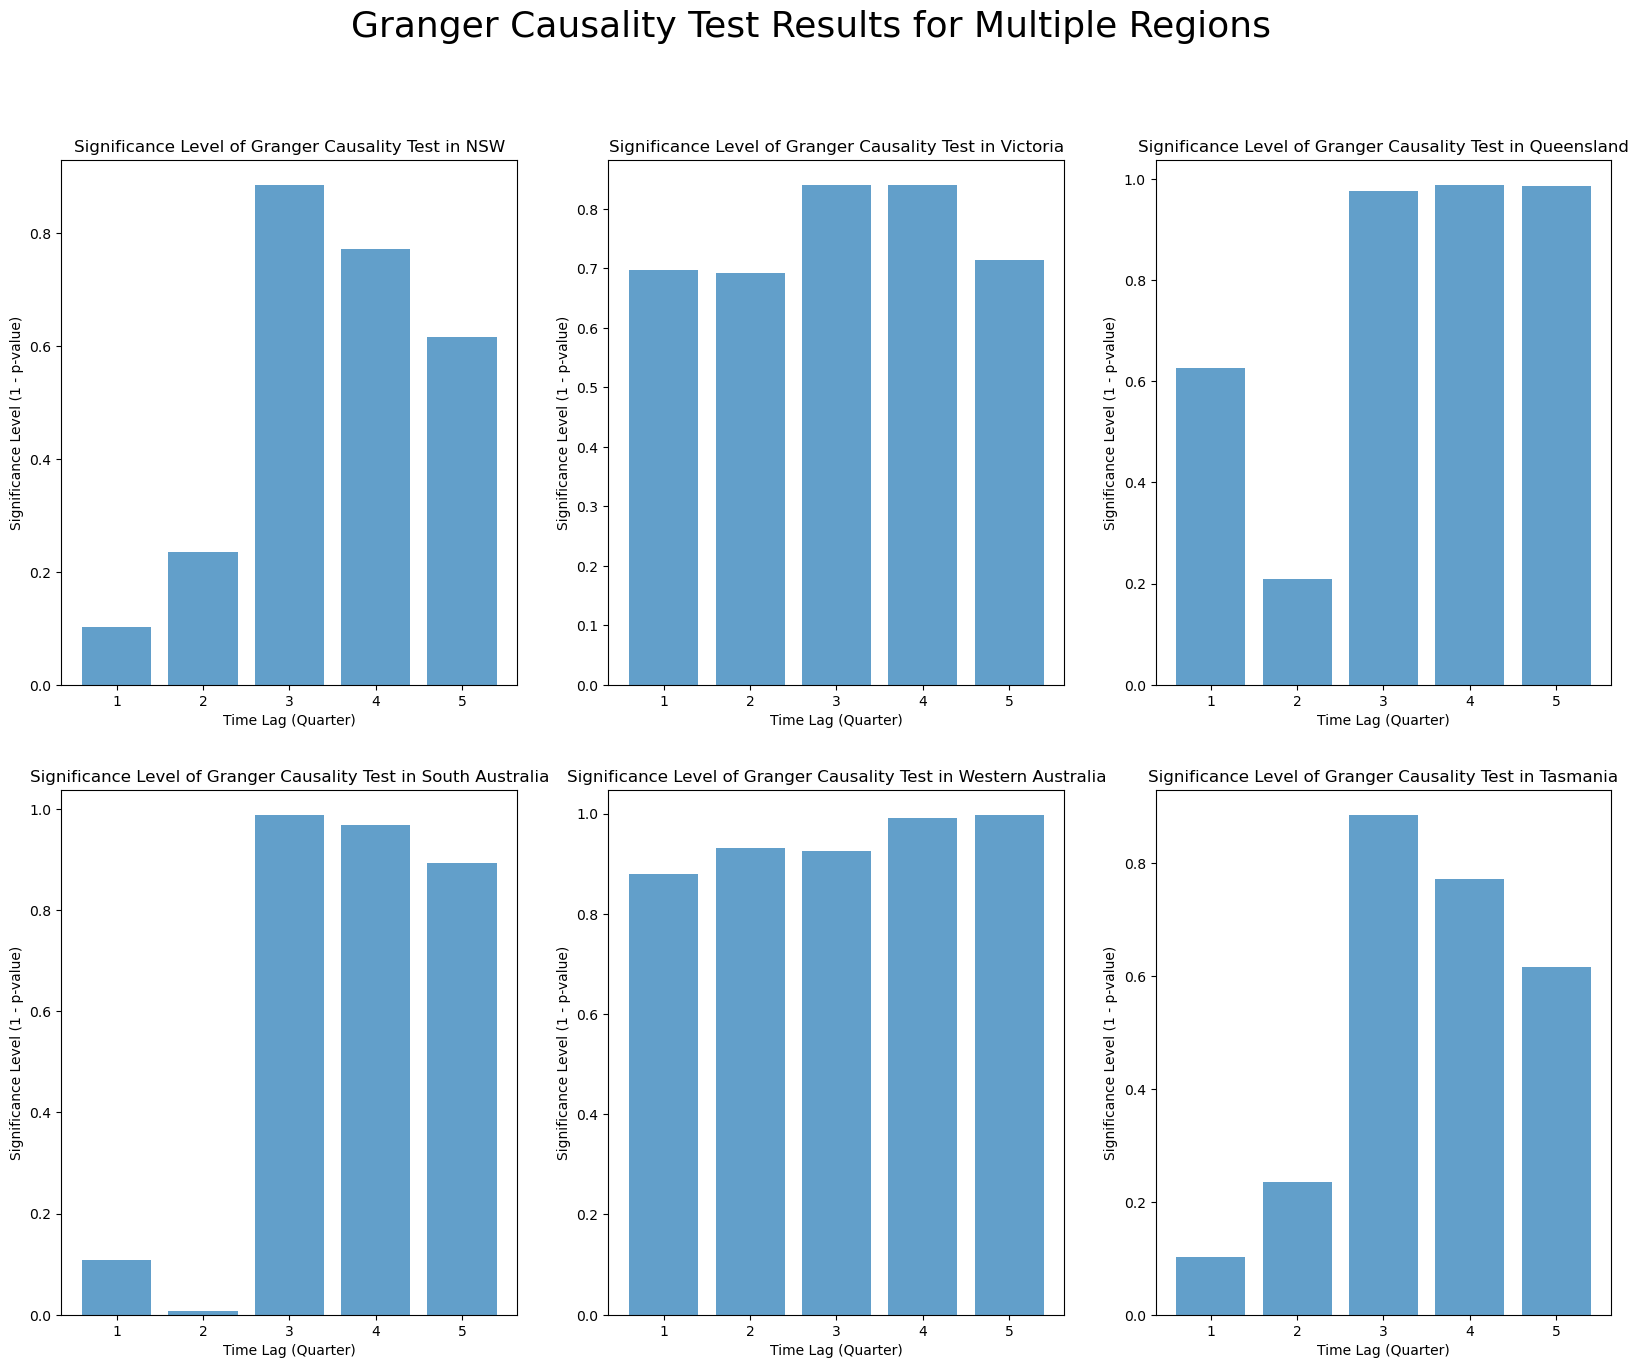

In [278]:
plt.figure(figsize=(20, 15))
plt.suptitle('Granger Causality Test Results for Multiple Regions', fontsize=26)
plt.subplot(2, 3, 1)
plt.bar(gc_df1['Lag'], gc_df1['significance level'], alpha=0.7)
plt.xlabel('Time Lag (Quarter)')
plt.ylabel('Significance Level (1 - p-value)')
plt.title('Significance Level of Granger Causality Test in NSW')

plt.subplot(2, 3, 2)
plt.bar(gc_df2['Lag'], gc_df2['significance level'], alpha=0.7)
plt.xlabel('Time Lag (Quarter)')
plt.ylabel('Significance Level (1 - p-value)')
plt.title('Significance Level of Granger Causality Test in Victoria')

plt.subplot(2, 3, 3)
plt.bar(gc_df3['Lag'], gc_df3['significance level'], alpha=0.7)
plt.xlabel('Time Lag (Quarter)')
plt.ylabel('Significance Level (1 - p-value)')
plt.title('Significance Level of Granger Causality Test in Queensland')

plt.subplot(2, 3, 4)
plt.bar(gc_df4['Lag'], gc_df4['significance level'], alpha=0.7)
plt.xlabel('Time Lag (Quarter)')
plt.ylabel('Significance Level (1 - p-value)')
plt.title('Significance Level of Granger Causality Test in South Australia')

plt.subplot(2, 3, 5)
plt.bar(gc_df5['Lag'], gc_df5['significance level'], alpha=0.7)
plt.xlabel('Time Lag (Quarter)')
plt.ylabel('Significance Level (1 - p-value)')
plt.title('Significance Level of Granger Causality Test in Western Australia')

plt.subplot(2, 3, 6)
plt.bar(gc_df1['Lag'], gc_df1['significance level'], alpha=0.7)
plt.xlabel('Time Lag (Quarter)')
plt.ylabel('Significance Level (1 - p-value)')
plt.title('Significance Level of Granger Causality Test in Tasmania')

plt.show()

In [279]:
r_merged_data1 = merged_data[merged_data['Region'] == '1: New South Wales']
max_lag = 5
result = grangercausalitytests(r_merged_data1[['Turnover', 'cpi']], max_lag, verbose=True)
ssr_ftest_pvalues = [result[lag][0]['ssr_ftest'][1] for lag in range(1, max_lag + 1)]
r_gc_df1 = pd.DataFrame({'Lag': range(1, max_lag + 1), 'SSR-based F-test p-value': ssr_ftest_pvalues})
r_gc_df1['significance level'] = 1 - r_gc_df1['SSR-based F-test p-value']

r_merged_data2 = merged_data[merged_data['Region'] == '2: Victoria']
max_lag = 5
result = grangercausalitytests(r_merged_data2[['Turnover', 'cpi']], max_lag, verbose=True)
ssr_ftest_pvalues = [result[lag][0]['ssr_ftest'][1] for lag in range(1, max_lag + 1)]
r_gc_df2 = pd.DataFrame({'Lag': range(1, max_lag + 1), 'SSR-based F-test p-value': ssr_ftest_pvalues})
r_gc_df2['significance level'] = 1 - r_gc_df2['SSR-based F-test p-value']

r_merged_data3 = merged_data[merged_data['Region'] == '3: Queensland']
max_lag = 5
result = grangercausalitytests(r_merged_data3[['Turnover', 'cpi']], max_lag, verbose=True)
ssr_ftest_pvalues = [result[lag][0]['ssr_ftest'][1] for lag in range(1, max_lag + 1)]
r_gc_df3 = pd.DataFrame({'Lag': range(1, max_lag + 1), 'SSR-based F-test p-value': ssr_ftest_pvalues})
r_gc_df3['significance level'] = 1 - r_gc_df3['SSR-based F-test p-value']

r_merged_data4 = merged_data[merged_data['Region'] == '4: South Australia']
max_lag = 5
result = grangercausalitytests(r_merged_data4[['Turnover', 'cpi']], max_lag, verbose=True)
ssr_ftest_pvalues = [result[lag][0]['ssr_ftest'][1] for lag in range(1, max_lag + 1)]
r_gc_df4 = pd.DataFrame({'Lag': range(1, max_lag + 1), 'SSR-based F-test p-value': ssr_ftest_pvalues})
r_gc_df4['significance level'] = 1 - r_gc_df4['SSR-based F-test p-value']

r_merged_data5 = merged_data[merged_data['Region'] == '5: Western Australia']
max_lag = 5
result = grangercausalitytests(r_merged_data5[['Turnover', 'cpi']], max_lag, verbose=True)
ssr_ftest_pvalues = [result[lag][0]['ssr_ftest'][1] for lag in range(1, max_lag + 1)]
r_gc_df5 = pd.DataFrame({'Lag': range(1, max_lag + 1), 'SSR-based F-test p-value': ssr_ftest_pvalues})
r_gc_df5['significance level'] = 1 - r_gc_df5['SSR-based F-test p-value']

r_merged_data6 = merged_data[merged_data['Region'] == '6: Tasmania']
max_lag = 6
result = grangercausalitytests(r_merged_data6[['Turnover', 'cpi']], max_lag, verbose=True)
ssr_ftest_pvalues = [result[lag][0]['ssr_ftest'][1] for lag in range(1, max_lag + 1)]
r_gc_df6 = pd.DataFrame({'Lag': range(1, max_lag + 1), 'SSR-based F-test p-value': ssr_ftest_pvalues})
r_gc_df6['significance level'] = 1 - r_gc_df6['SSR-based F-test p-value']


C:\Users\39642\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning:

verbose is deprecated since functions should not print results

C:\Users\39642\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning:

verbose is deprecated since functions should not print results

C:\Users\39642\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning:

verbose is deprecated since functions should not print results

C:\Users\39642\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning:

verbose is deprecated since functions should not print results

C:\Users\39642\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning:

verbose is deprecated since functions should not print results




Granger Causality
number of lags (no zero) 1
ssr based F test:         F=57.3635 , p=0.0000  , df_denom=48, df_num=1
ssr based chi2 test:   chi2=60.9487 , p=0.0000  , df=1
likelihood ratio test: chi2=40.0970 , p=0.0000  , df=1
parameter F test:         F=57.3635 , p=0.0000  , df_denom=48, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=27.8225 , p=0.0000  , df_denom=45, df_num=2
ssr based chi2 test:   chi2=61.8278 , p=0.0000  , df=2
likelihood ratio test: chi2=40.2469 , p=0.0000  , df=2
parameter F test:         F=27.8225 , p=0.0000  , df_denom=45, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=24.9208 , p=0.0000  , df_denom=42, df_num=3
ssr based chi2 test:   chi2=87.2228 , p=0.0000  , df=3
likelihood ratio test: chi2=50.1011 , p=0.0000  , df=3
parameter F test:         F=24.9208 , p=0.0000  , df_denom=42, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.0873  , p=0.3762  , df_d

C:\Users\39642\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning:

verbose is deprecated since functions should not print results



In [176]:
#Question 3
covid_m = merged_data[merged_data['Time Period']>='2020-Q1']
noncovid_m = merged_data[merged_data['Time Period']<'2020-Q1']
covid_m.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84 entries, 228 to 311
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Industry     84 non-null     object 
 1   Region       84 non-null     object 
 2   Turnover     84 non-null     float64
 3   Time Period  84 non-null     object 
 4   cpi          84 non-null     float64
 5   Index        84 non-null     object 
dtypes: float64(2), object(4)
memory usage: 4.6+ KB


In [177]:
covid_correlation = covid_m['Turnover'].corr(covid_m['cpi'])
print("Covid correlation between 'total industry turnover by quarter' and 'CPI':", covid_correlation)
noncovid_correlation = noncovid_m['Turnover'].corr(noncovid_m['cpi'])
print("Noncovid correlation between 'total industry turnover by quarter' and 'CPI':", noncovid_correlation)

Covid correlation between 'total industry turnover by quarter' and 'CPI': 0.14726362653762706
Noncovid correlation between 'total industry turnover by quarter' and 'CPI': 0.2591578221168029


In [266]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Assuming you have loaded the COVID and non-COVID data into dataframes: covid_m and noncovid_m
# Make sure to have the necessary data loaded before running this code

regions = covid_m['Region'].unique()

coef_diff = []

for region in regions:
    covid_reg = covid_m[covid_m['Region'] == region]
    noncovid_reg = noncovid_m[noncovid_m['Region'] == region]
    X_covid = covid_reg[['cpi']]
    y_covid = covid_reg['Turnover']

    model_covid = LinearRegression().fit(X_covid, y_covid)

    X_noncovid = noncovid_reg[['cpi']]
    y_noncovid = noncovid_reg['Turnover']

    model_noncovid = LinearRegression().fit(X_noncovid, y_noncovid)

    coef_covid = model_covid.coef_[0]
    coef_noncovid = model_noncovid.coef_[0]

    coef_d = coef_covid - coef_noncovid
    coef_diff.append(coef_d)


C:\Users\39642\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning:

verbose is deprecated since functions should not print results

C:\Users\39642\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning:

verbose is deprecated since functions should not print results

C:\Users\39642\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning:

verbose is deprecated since functions should not print results

C:\Users\39642\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning:

verbose is deprecated since functions should not print results

C:\Users\39642\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning:

verbose is deprecated since functions should not print results

C:\Users\39642\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning:

verbose is deprecated since functions should not print results




Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3228  , p=0.5825  , df_denom=10, df_num=1
ssr based chi2 test:   chi2=0.4196  , p=0.5171  , df=1
likelihood ratio test: chi2=0.4130  , p=0.5204  , df=1
parameter F test:         F=0.3228  , p=0.5825  , df_denom=10, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2406  , p=0.3458  , df_denom=7, df_num=2
ssr based chi2 test:   chi2=4.2535  , p=0.1192  , df=2
likelihood ratio test: chi2=3.6408  , p=0.1620  , df=2
parameter F test:         F=1.2406  , p=0.3458  , df_denom=7, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5551  , p=0.6719  , df_denom=4, df_num=3
ssr based chi2 test:   chi2=4.5793  , p=0.2053  , df=3
likelihood ratio test: chi2=3.8285  , p=0.2806  , df=3
parameter F test:         F=0.5551  , p=0.6719  , df_denom=4, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4296  , p=0.5270  , df_denom

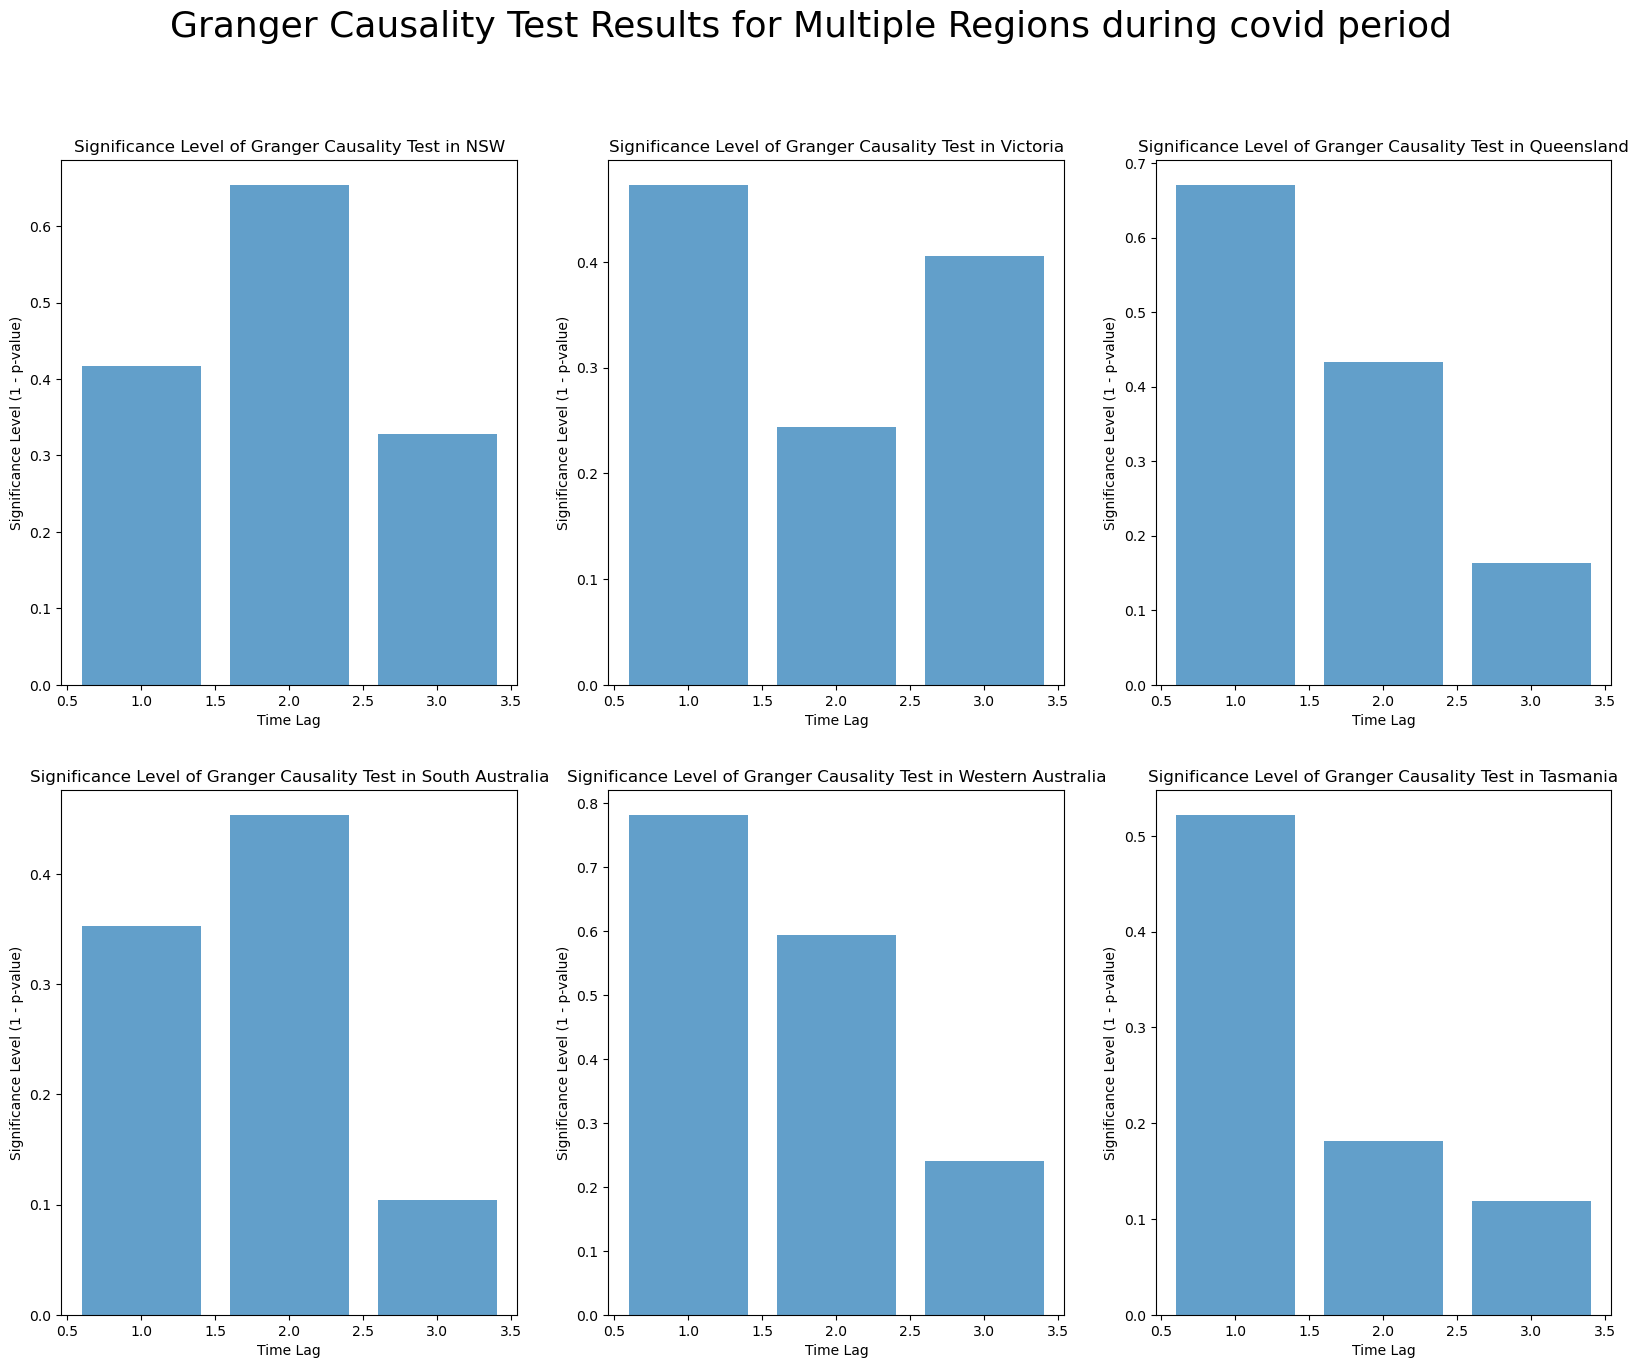

In [240]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests

# Assuming you have a DataFrame called 'covid_m'
c_data1 = covid_m[covid_m['Region'] == '1: New South Wales']
max_lag = 3
result = grangercausalitytests(c_data1[['cpi', 'Turnover']], max_lag, verbose=True)
ssr_ftest_pvalues = [result[lag][0]['ssr_ftest'][1] for lag in range(1, max_lag + 1)]
c_gc1 = pd.DataFrame({'Lag': range(1, max_lag + 1), 'SSR-based F-test p-value': ssr_ftest_pvalues})
c_gc1['significance level'] = 1 - c_gc1['SSR-based F-test p-value']

c_data2 = covid_m[covid_m['Region'] == '2: Victoria']
max_lag = 3
result = grangercausalitytests(c_data2[['cpi', 'Turnover']], max_lag, verbose=True)
ssr_ftest_pvalues = [result[lag][0]['ssr_ftest'][1] for lag in range(1, max_lag + 1)]
c_gc2 = pd.DataFrame({'Lag': range(1, max_lag + 1), 'SSR-based F-test p-value': ssr_ftest_pvalues})
c_gc2['significance level'] = 1 - c_gc2['SSR-based F-test p-value']

c_data3 = covid_m[covid_m['Region'] == '3: Queensland']
max_lag = 3
result = grangercausalitytests(c_data3[['cpi', 'Turnover']], max_lag, verbose=True)
ssr_ftest_pvalues = [result[lag][0]['ssr_ftest'][1] for lag in range(1, max_lag + 1)]
c_gc3 = pd.DataFrame({'Lag': range(1, max_lag + 1), 'SSR-based F-test p-value': ssr_ftest_pvalues})
c_gc3['significance level'] = 1 - c_gc3['SSR-based F-test p-value']

c_data4 = covid_m[covid_m['Region'] == '4: South Australia']
max_lag = 3
result = grangercausalitytests(c_data4[['cpi', 'Turnover']], max_lag, verbose=True)
ssr_ftest_pvalues = [result[lag][0]['ssr_ftest'][1] for lag in range(1, max_lag + 1)]
c_gc4 = pd.DataFrame({'Lag': range(1, max_lag + 1), 'SSR-based F-test p-value': ssr_ftest_pvalues})
c_gc4['significance level'] = 1 - c_gc4['SSR-based F-test p-value']

c_data5 = covid_m[covid_m['Region'] == '5: Western Australia']
max_lag = 3
result = grangercausalitytests(c_data5[['cpi', 'Turnover']], max_lag, verbose=True)
ssr_ftest_pvalues = [result[lag][0]['ssr_ftest'][1] for lag in range(1, max_lag + 1)]
c_gc5 = pd.DataFrame({'Lag': range(1, max_lag + 1), 'SSR-based F-test p-value': ssr_ftest_pvalues})
c_gc5['significance level'] = 1 - c_gc5['SSR-based F-test p-value']

c_data6 = covid_m[covid_m['Region'] == '6: Tasmania']
max_lag = 3
result = grangercausalitytests(c_data6[['cpi', 'Turnover']], max_lag, verbose=True)
ssr_ftest_pvalues = [result[lag][0]['ssr_ftest'][1] for lag in range(1, max_lag + 1)]
c_gc6 = pd.DataFrame({'Lag': range(1, max_lag + 1), 'SSR-based F-test p-value': ssr_ftest_pvalues})
c_gc6['significance level'] = 1 - c_gc6['SSR-based F-test p-value']


plt.figure(figsize=(20, 15))
plt.suptitle('Granger Causality Test Results for Multiple Regions during covid period', fontsize=26)

plt.subplot(2, 3, 1)
plt.bar(c_gc1['Lag'], c_gc1['significance level'], alpha=0.7)
plt.xlabel('Time Lag (Quarter)')
plt.ylabel('Significance Level (1 - p-value)')
plt.title('Significance Level of Granger Causality Test in NSW')

plt.subplot(2, 3, 2)
plt.bar(c_gc2['Lag'], c_gc2['significance level'], alpha=0.7)
plt.xlabel('Time Lag (Quarter)')
plt.ylabel('Significance Level (1 - p-value)')
plt.title('Significance Level of Granger Causality Test in Victoria')

plt.subplot(2, 3, 3)
plt.bar(c_gc3['Lag'], c_gc3['significance level'], alpha=0.7)
plt.xlabel('Time Lag (Quarter)')
plt.ylabel('Significance Level (1 - p-value)')
plt.title('Significance Level of Granger Causality Test in Queensland')

plt.subplot(2, 3, 4)
plt.bar(c_gc4['Lag'], c_gc4['significance level'], alpha=0.7)
plt.xlabel('Time Lag (Quarter)')
plt.ylabel('Significance Level (1 - p-value)')
plt.title('Significance Level of Granger Causality Test in South Australia')

plt.subplot(2, 3, 5)
plt.bar(c_gc5['Lag'], c_gc5['significance level'], alpha=0.7)
plt.xlabel('Time Lag (Quarter)')
plt.ylabel('Significance Level (1 - p-value)')
plt.title('Significance Level of Granger Causality Test in Western Australia')

plt.subplot(2, 3, 6)
plt.bar(c_gc6['Lag'], c_gc6['significance level'], alpha=0.7)
plt.xlabel('Time Lag (Quarter)')
plt.ylabel('Significance Level (1 - p-value)')
plt.title('Significance Level of Granger Causality Test in Tasmania')

plt.show()


C:\Users\39642\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning:

verbose is deprecated since functions should not print results

C:\Users\39642\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning:

verbose is deprecated since functions should not print results

C:\Users\39642\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning:

verbose is deprecated since functions should not print results

C:\Users\39642\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning:

verbose is deprecated since functions should not print results

C:\Users\39642\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning:

verbose is deprecated since functions should not print results

C:\Users\39642\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning:

verbose is deprecated since functions should not print results




Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2775  , p=0.1405  , df_denom=34, df_num=1
ssr based chi2 test:   chi2=2.4784  , p=0.1154  , df=1
likelihood ratio test: chi2=2.3989  , p=0.1214  , df=1
parameter F test:         F=2.2775  , p=0.1405  , df_denom=34, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1688  , p=0.3241  , df_denom=31, df_num=2
ssr based chi2 test:   chi2=2.7146  , p=0.2574  , df=2
likelihood ratio test: chi2=2.6171  , p=0.2702  , df=2
parameter F test:         F=1.1688  , p=0.3241  , df_denom=31, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.1951  , p=0.0387  , df_denom=28, df_num=3
ssr based chi2 test:   chi2=11.9817 , p=0.0074  , df=3
likelihood ratio test: chi2=10.3043 , p=0.0161  , df=3
parameter F test:         F=3.1951  , p=0.0387  , df_denom=28, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.3515  , p=0.0250  , df_d

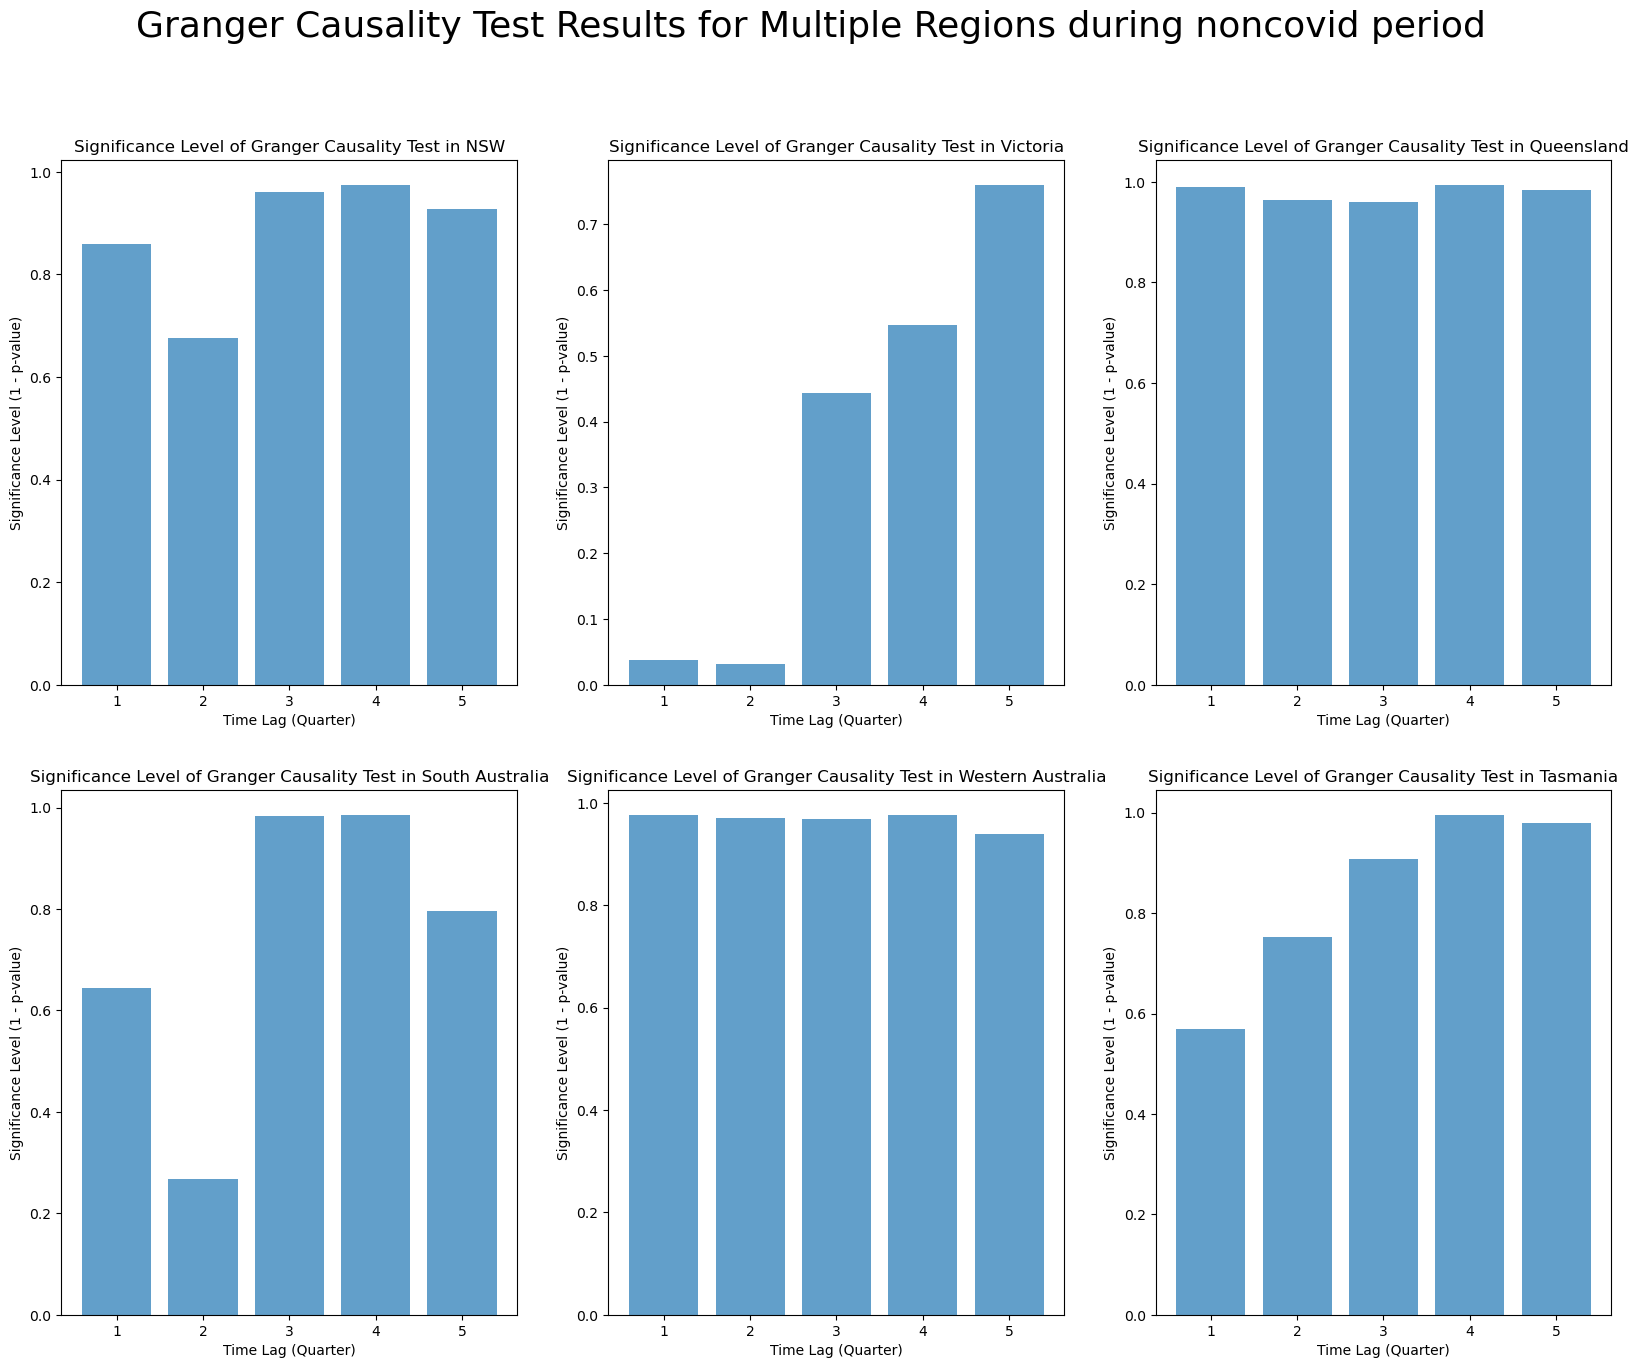

In [280]:
nc_data1 = noncovid_m[noncovid_m['Region'] == '1: New South Wales']
max_lag = 5
result = grangercausalitytests(nc_data1[['cpi', 'Turnover']], max_lag, verbose=True)
ssr_ftest_pvalues = [result[lag][0]['ssr_ftest'][1] for lag in range(1, max_lag + 1)]
nc_gc1 = pd.DataFrame({'Lag': range(1, max_lag + 1), 'SSR-based F-test p-value': ssr_ftest_pvalues})
nc_gc1['significance level'] = 1 - nc_gc1['SSR-based F-test p-value']

nc_data2 = noncovid_m[noncovid_m['Region'] == '2: Victoria']
max_lag = 5
result = grangercausalitytests(nc_data2[['cpi', 'Turnover']], max_lag, verbose=True)
ssr_ftest_pvalues = [result[lag][0]['ssr_ftest'][1] for lag in range(1, max_lag + 1)]
nc_gc2 = pd.DataFrame({'Lag': range(1, max_lag + 1), 'SSR-based F-test p-value': ssr_ftest_pvalues})
nc_gc2['significance level'] = 1 - nc_gc2['SSR-based F-test p-value']

nc_data3 = noncovid_m[noncovid_m['Region'] == '3: Queensland']
max_lag = 5
result = grangercausalitytests(nc_data3[['cpi', 'Turnover']], max_lag, verbose=True)
ssr_ftest_pvalues = [result[lag][0]['ssr_ftest'][1] for lag in range(1, max_lag + 1)]
nc_gc3 = pd.DataFrame({'Lag': range(1, max_lag + 1), 'SSR-based F-test p-value': ssr_ftest_pvalues})
nc_gc3['significance level'] = 1 - nc_gc3['SSR-based F-test p-value']

nc_data4 = noncovid_m[noncovid_m['Region'] == '4: South Australia']
max_lag = 5
result = grangercausalitytests(nc_data4[['cpi', 'Turnover']], max_lag, verbose=True)
ssr_ftest_pvalues = [result[lag][0]['ssr_ftest'][1] for lag in range(1, max_lag + 1)]
nc_gc4 = pd.DataFrame({'Lag': range(1, max_lag + 1), 'SSR-based F-test p-value': ssr_ftest_pvalues})
nc_gc4['significance level'] = 1 - nc_gc4['SSR-based F-test p-value']

nc_data5 = noncovid_m[noncovid_m['Region'] == '5: Western Australia']
max_lag = 5
result = grangercausalitytests(nc_data5[['cpi', 'Turnover']], max_lag, verbose=True)
ssr_ftest_pvalues = [result[lag][0]['ssr_ftest'][1] for lag in range(1, max_lag + 1)]
nc_gc5 = pd.DataFrame({'Lag': range(1, max_lag + 1), 'SSR-based F-test p-value': ssr_ftest_pvalues})
nc_gc5['significance level'] = 1 - nc_gc5['SSR-based F-test p-value']

nc_data6 = noncovid_m[noncovid_m['Region'] == '6: Tasmania']
max_lag = 5
result = grangercausalitytests(nc_data6[['cpi', 'Turnover']], max_lag, verbose=True)
ssr_ftest_pvalues = [result[lag][0]['ssr_ftest'][1] for lag in range(1, max_lag + 1)]
nc_gc6 = pd.DataFrame({'Lag': range(1, max_lag + 1), 'SSR-based F-test p-value': ssr_ftest_pvalues})
nc_gc6['significance level'] = 1 - nc_gc6['SSR-based F-test p-value']

plt.figure(figsize=(20, 15))
plt.suptitle('Granger Causality Test Results for Multiple Regions during noncovid period', fontsize=26)

plt.subplot(2, 3, 1)
plt.bar(nc_gc1['Lag'], nc_gc1['significance level'], alpha=0.7)
plt.xlabel('Time Lag (Quarter)')
plt.ylabel('Significance Level (1 - p-value)')
plt.title('Significance Level of Granger Causality Test in NSW')

plt.subplot(2, 3, 2)
plt.bar(nc_gc2['Lag'], nc_gc2['significance level'], alpha=0.7)
plt.xlabel('Time Lag (Quarter)')
plt.ylabel('Significance Level (1 - p-value)')
plt.title('Significance Level of Granger Causality Test in Victoria')

plt.subplot(2, 3, 3)
plt.bar(nc_gc3['Lag'], nc_gc3['significance level'], alpha=0.7)
plt.xlabel('Time Lag (Quarter)')
plt.ylabel('Significance Level (1 - p-value)')
plt.title('Significance Level of Granger Causality Test in Queensland')

plt.subplot(2, 3, 4)
plt.bar(nc_gc4['Lag'], nc_gc4['significance level'], alpha=0.7)
plt.xlabel('Time Lag (Quarter)')
plt.ylabel('Significance Level (1 - p-value)')
plt.title('Significance Level of Granger Causality Test in South Australia')

plt.subplot(2, 3, 5)
plt.bar(nc_gc5['Lag'], nc_gc5['significance level'], alpha=0.7)
plt.xlabel('Time Lag (Quarter)')
plt.ylabel('Significance Level (1 - p-value)')
plt.title('Significance Level of Granger Causality Test in Western Australia')

plt.subplot(2, 3, 6)
plt.bar(nc_gc6['Lag'], nc_gc6['significance level'], alpha=0.7)
plt.xlabel('Time Lag (Quarter)')
plt.ylabel('Significance Level (1 - p-value)')
plt.title('Significance Level of Granger Causality Test in Tasmania')

plt.show()


In [181]:
category_mapping = {
    '10001: All groups CPI': '20: Total',
    '20001: Food and non-alcoholic beverages': '41: Food retailing',
    '20002: Clothing and footwear': '43: Clothing, footwear and personal accessory retailing',
    '20003: Housing': '42: Household goods retailing',
    '20004: Furnishings, household equipment and services': '42: Household goods retailing',
    '20005: Transport': '45: Other retailing',
    '20006: Alcohol and tobacco': '45: Other retailing',
    '115486: Health': '45: Other retailing',
    '115488: Communication': '45: Other retailing',
    '115489: Recreation and culture': '45: Other retailing',
    '115493: Education': '45: Other retailing',
    '126670: Insurance and financial services': '45: Other retailing'
}

cpi2=cpi_df.copy()
cpi2['Industry']= cpi_df['Index'].replace(category_mapping)
md_sector = quarterly_turnover.merge(cpi2, on=['Time Period', 'Industry','Region'], how='inner')
md_sector

,Industry,Region,Turnover,Time Period,cpi,Index
0,20: Total,1: New South Wales,18534.7,2010-Q3,96.3,10001: All groups CPI
1,20: Total,2: Victoria,15153.5,2010-Q3,96.3,10001: All groups CPI
2,20: Total,3: Queensland,12511.4,2010-Q3,96.9,10001: All groups CPI
3,20: Total,4: South Australia,4244.9,2010-Q3,96.2,10001: All groups CPI
4,20: Total,5: Western Australia,6483.0,2010-Q3,96.9,10001: All groups CPI
...,...,...,...,...,...,...
3739,45: Other retailing,6: Tasmania,257.7,2023-Q2,127.6,126670: Insurance and financial services
3740,45: Other retailing,6: Tasmania,257.7,2023-Q2,76.7,115488: Communication
3741,45: Other retailing,6: Tasmania,257.7,2023-Q2,130.5,20005: Transport
3742,45: Other retailing,6: Tasmania,257.7,2023-Q2,149.7,115493: Education


In [271]:
covid_md_sector = md_sector[md_sector['Time Period'] >= '2020-Q1']
noncovid_md_sector = md_sector[md_sector['Time Period'] < '2020-Q1']
sectors = md_sector['Industry'].unique()

coef_diff1 = []

coef_covid1_list = []  # Store COVID coefficients for each sector
coef_noncovid1_list = []  # Store non-COVID coefficients for each sector

for sector in sectors:
    covid_reg1 = covid_md_sector[covid_md_sector['Industry'] == sector]
    noncovid_reg1 = noncovid_md_sector[noncovid_md_sector['Industry'] == sector]
    
    X_covid1 = covid_reg1[['cpi']]
    y_covid1 = covid_reg1['Turnover']

    model_covid1 = LinearRegression().fit(X_covid1, y_covid1)

    X_noncovid1 = noncovid_reg1[['cpi']]
    y_noncovid1 = noncovid_reg1['Turnover']

    model_noncovid1 = LinearRegression().fit(X_noncovid1, y_noncovid1)

    coef_covid1 = model_covid1.coef_[0]
    coef_noncovid1 = model_noncovid1.coef_[0]

    coef_covid1_list.append(coef_covid1)
    coef_noncovid1_list.append(coef_noncovid1)

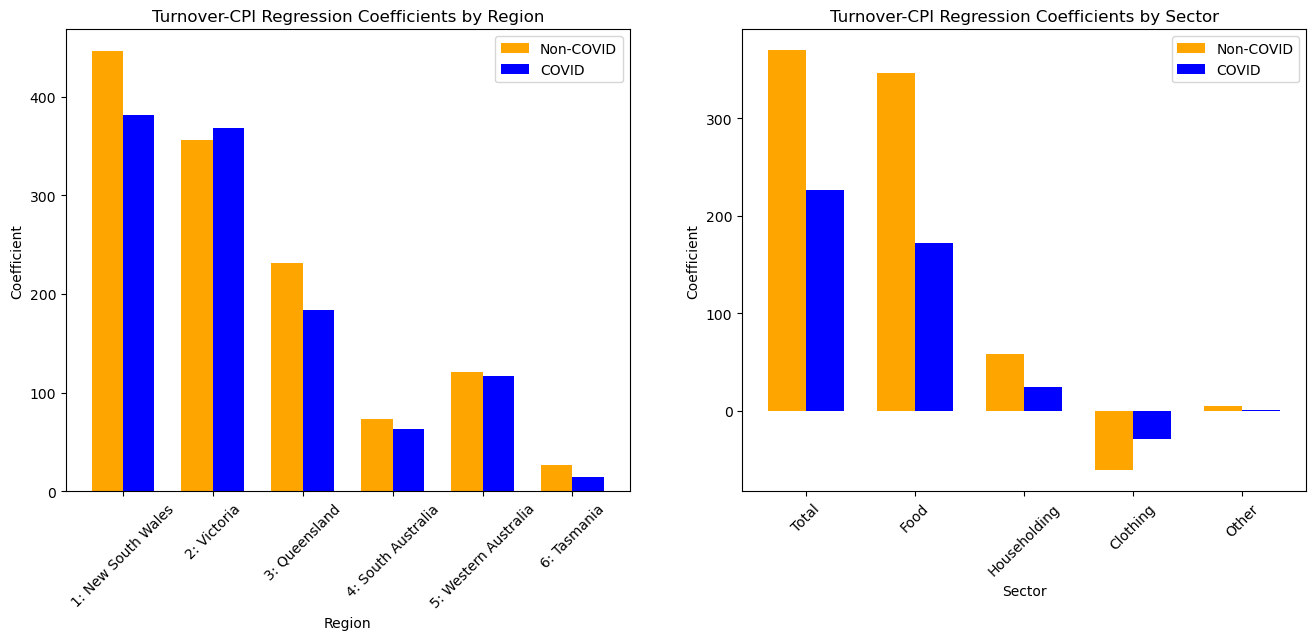

In [281]:
sec = ["Total", "Food", "Householding", "Clothing", "Other"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
bar_width = 0.35
bar_positions = range(len(regions))

bar1 = ax1.bar(bar_positions, [model.coef_[0] for model in models_noncovid], bar_width, label='Non-COVID', color='orange')
bar2 = ax1.bar([pos + bar_width for pos in bar_positions], [model.coef_[0] for model in models_covid], bar_width, label='COVID', color='blue')

ax1.set_xlabel("Region")
ax1.set_title("Turnover-CPI Regression Coefficients by Region")
ax1.set_ylabel("Coefficient")
ax1.set_xticks([pos + bar_width / 2 for pos in bar_positions])
ax1.set_xticklabels(regions, rotation = 45)
ax1.legend()

bar_positions = range(len(sectors))

bar1 = ax2.bar(bar_positions, coef_noncovid1_list, bar_width, label='Non-COVID', color='orange')
bar2 = ax2.bar([pos + bar_width for pos in bar_positions], coef_covid1_list, bar_width, label='COVID', color='blue')

ax2.set_xlabel("Sector")
ax2.set_title("Turnover-CPI Regression Coefficients by Sector")
ax2.set_ylabel("Coefficient")
ax2.set_xticks([pos + bar_width / 2 for pos in bar_positions])
ax2.set_xticklabels(sec, rotation = 45)
ax2.legend()

plt.show()
